In [143]:
import numpy as np
import mesa
import matplotlib.pyplot as plt
import random

In [144]:
def simple_dist(vals):
  """
      Computes probability distribution.
  """

  total = np.sum(vals)

  for i in range(len(vals)):
    vals[i] = vals[i]/total

  return vals

In [145]:
class ModifiedGrid(mesa.space.MultiGrid):
    """
       Defines the grid with added new featue of pheromone_vals to store pheromone values.
    """
    def __init__(self, width, height, torus):
        super().__init__(width, height, torus)

        self.pheromone_vals = np.zeros((height,width))

    def get_pheromone_val(self):
        return self.pheromone_vals

In [146]:
class AntModel(mesa.Model):
    """
        The main class to run the simulation. Initialize agent(s) and grid.
    """
    def __init__(self, n, width, height):
        super().__init__(self, n, width, height)
        self.num_agents = n
        self.grid = ModifiedGrid(width, height, True)
        self.schedule = mesa.time.BaseScheduler(self)

        for i in range(n):
          a = AntAgent(i, self)
          self.schedule.add(a)
          x = random.randint(0,self.grid.width-1)
          self.grid.place_agent(a, (x,0))

    def step(self):
        self.schedule.step()
    
class AntAgent(mesa.Agent):
    """
        Defines an agent with an ability to compute possible steps and move to one of them.
    """
    def __init__(self, id, model):
        super().__init__(id, model)
    
    def move(self):
        possible_steps = self.get_possible_steps()
        new_position = self.choose_next_pos(possible_steps)
        self.model.grid.pheromone_vals[self.pos[1]][self.pos[0]] += 1.0 #leaves pheromone before moving to the next cell
        self.model.grid.move_agent(self, new_position)
        
    def get_possible_steps(self):
        x,y = self.pos
        pos_y = y + 1
        
        if x - 1 < 0:
            pos_x_1 = self.model.grid.width - 1
        else:
            pos_x_1 = x - 1
        
        pos_x_2 = x

        if x + 1 > 49:
            pos_x_3 = 0
        else:
            pos_x_3 = x + 1
        
        return [(pos_x_1, pos_y),(pos_x_2, pos_y),(pos_x_3, pos_y)]
        
    def choose_next_pos(self, possible_steps):
        ps1, ps2, ps3 = possible_steps 

        normalised_pheromones = simple_dist([self.model.grid.pheromone_vals[ps1[1]][ps1[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps2[1]][ps2[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps3[1]][ps3[0]]+0.1])

        if normalised_pheromones[0] == normalised_pheromones[1] == normalised_pheromones[2]:
            next_pos = possible_steps[random.choice([0,1,2])]
        else:
            next_pos = random.choices(possible_steps, normalised_pheromones)[0]

        return next_pos
    
    def step(self):
        self.move()

In [147]:
def reward_func(model, reward_history, target, start, end, _lambda=2.0):
  """
      Calculates the reward according to the given scenaro by the 'target' parameter. 
  """

  for cell in model.grid.coord_iter():
    content, x, y = cell
    
    if content != [] and y == 499:
      agents_last_pos = (x, y) #-> x,y represents axis

  if target == "changing":
        
      target_area = range(0,14)
      if len(reward_history) >= 7000:
        target_area = range(30,44)
  
      if agents_last_pos[0] in target_area:
        score = 1
      else:
        score = 0

      reward = reward_history[-1] + (score - reward_history[-1])/_lambda

      return reward


  elif target == "double":
      target_area_1 = range(0,14)
      target_area_2 = range(29,43)
      
        
      if agents_last_pos[0] in target_area_1 or agents_last_pos[0] in target_area_2:
        score = 1
      else:
        score = 0

      reward = reward_history[-1] + (score - reward_history[-1])/_lambda

      return reward

  elif target == "sliding":
      
      target_area = range(start,end)
        
      if agents_last_pos[0] in target_area:
        score = 1
      else:
        score = 0

      reward = reward_history[-1] + (score - reward_history[-1])/_lambda

      return reward
  
  else:
     target_area = range(29,43)  
    
     if agents_last_pos[0] in target_area:
        score = 1
     else:
        score = 0   

     reward = reward_history[-1] + (score - reward_history[-1])/_lambda

     return reward
    
def decay(reward, pheromone_vals):
  """
      Calculates the decay rate.
  """
  decay_factor = 1 - (1/(495*reward+5))
  return pheromone_vals*decay_factor

In [148]:
def subtraction(pheromone_vals):
  """
      Applies subtraction of 0.01 to all pheromone values.
  """
  pheromone_vals -= 0.01
  for i in range(pheromone_vals.shape[0]):
    for j in range(pheromone_vals.shape[1]):
      if pheromone_vals[i][j] < 0:
        pheromone_vals[i][j] = 0
  return pheromone_vals

In [153]:
def run_simulation(target="normal", num_iterations=10000, num_agents=1, width=50, height=500, _lambda=2.0): 
  """
      Runs the simulation 'num_iterations' times.
  """
  start = 0
  end = 14
    
  model = AntModel(num_agents, width, height)
  for i in range(499):
      model.step()
  reward_history = [0]

  pheromone_data = []
  for iteration in range(1,num_iterations+1):
    pheromone_vals = model.grid.get_pheromone_val()

    #move the target by 1 at every 500 iterations
    if target == "sliding":
        if iteration % 500 == 0:
            start += 1
            end += 1
            
    reward = reward_func(model, reward_history, target, start, end, _lambda)
    reward_history.append(reward)
    pheromone_vals = decay(reward, pheromone_vals)
    model = AntModel(num_agents, width, height)
    pheromone_vals = subtraction(pheromone_vals)
    model.grid.pheromone_vals = pheromone_vals
    
    #collect the data for visualizing and analysing
    for i in range(499):
      model.step()
    if iteration == 1:
      pheromone_data.append(model.grid.pheromone_vals)
    if iteration == 100:
      pheromone_data.append(model.grid.pheromone_vals)
    elif iteration % 1000 == 0:
      pheromone_data.append(model.grid.pheromone_vals)
  return pheromone_data

In [150]:
def draw_graphs(pheromone_data):
  """
      Draw the graphs. Ticks need to be set according to the scenario being run.
  """

  fig,axs = plt.subplots(1,6, figsize=(15,10))
  
  axs[0].imshow(pheromone_data[1], interpolation="nearest")
  axs[0].set_xticks([29,43])
  axs[0].set_title("100")
  
  axs[1].imshow(pheromone_data[4], interpolation="nearest")
  axs[1].set_xticks([29,43])
  axs[1].set_title("3000")
  
  axs[2].imshow(pheromone_data[7], interpolation="nearest")
  axs[2].set_xticks([29,43])
  axs[2].set_title("6000")
  
  axs[3].imshow(pheromone_data[10], interpolation="nearest")
  axs[3].set_xticks([29,43])
  axs[3].set_title("9000")
  
  axs[4].imshow(pheromone_data[13], interpolation="nearest")
  axs[4].set_xticks([29,43])
  axs[4].set_title("12000")
  
  axs[5].imshow(pheromone_data[-1], interpolation="nearest")
  axs[5].set_xticks([29,43])
  axs[5].set_title("15000")


In [108]:
data_0 = run_simulation(target="changing", num_iterations=15000)

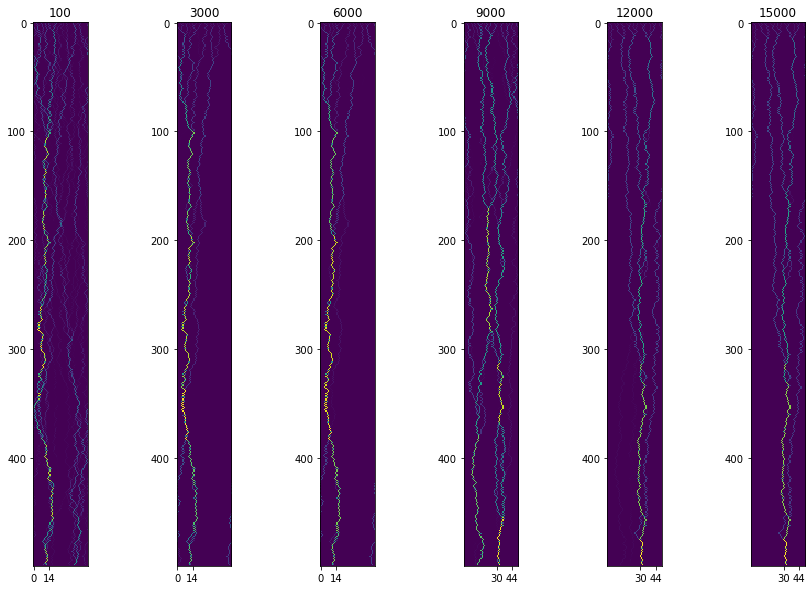

In [111]:
draw_graphs(data_0)

In [47]:
data_1 = run_simulation(target="normal", num_iterations=15000)

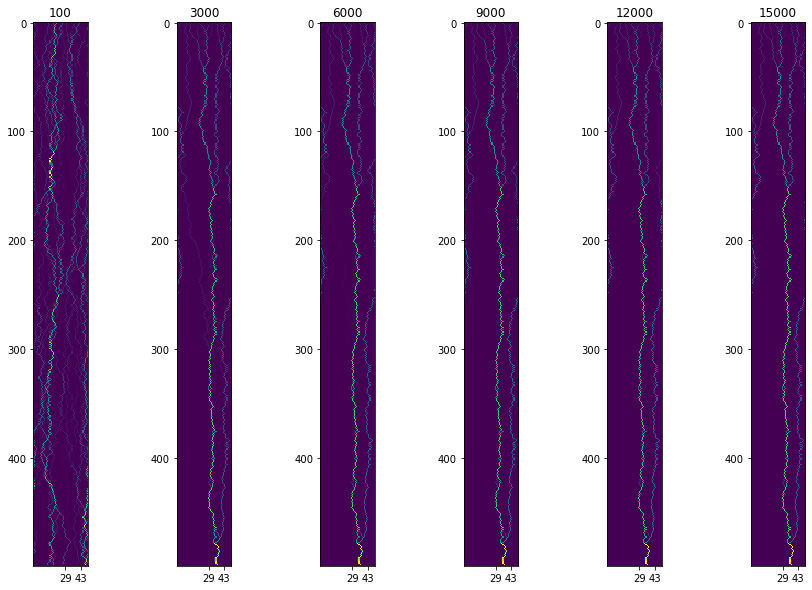

In [114]:
draw_graphs(data_1)

In [54]:
data_2 = run_simulation(target = "sliding", num_iterations = 15000)

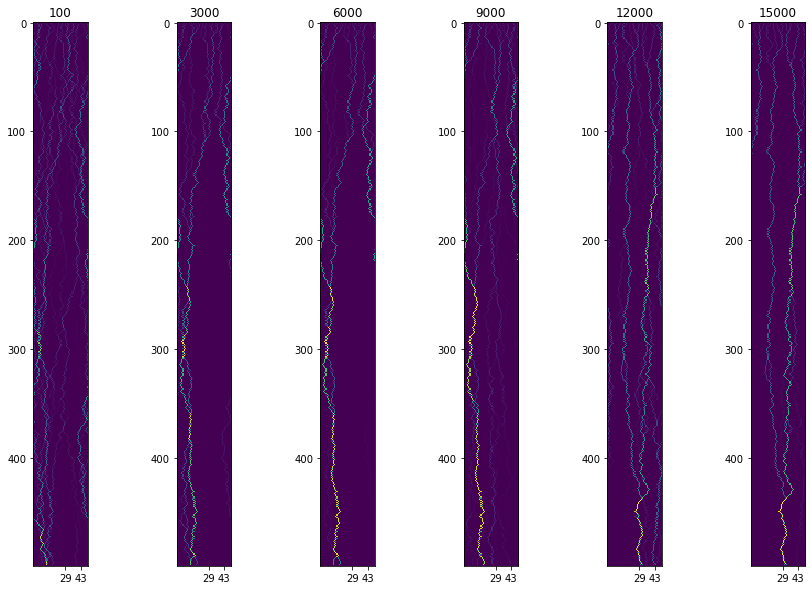

In [155]:
draw_graphs(data_2)

In [90]:
data_3 = run_simulation(target="changing", num_agents=10, num_iterations=15000)

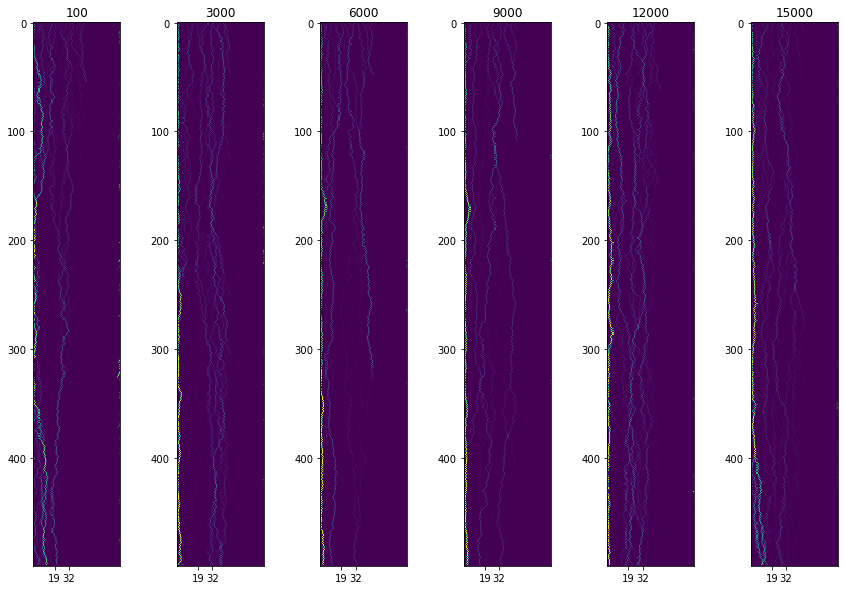

In [93]:
draw_graphs(data_3)

In [115]:
data_4 = run_simulation(target="sliding", num_iterations=15000)

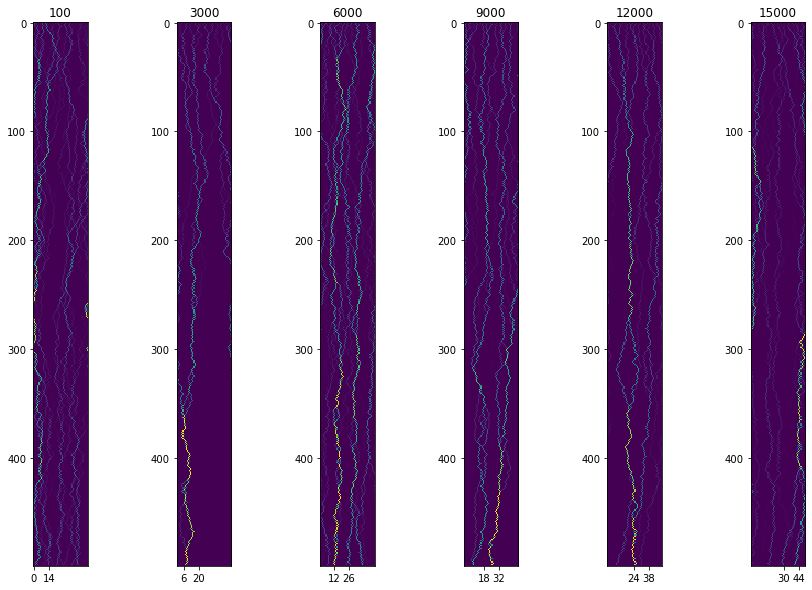

In [118]:
draw_graphs(data_4)

In [119]:
data_5 = run_simulation(target="double", num_iterations=15000)

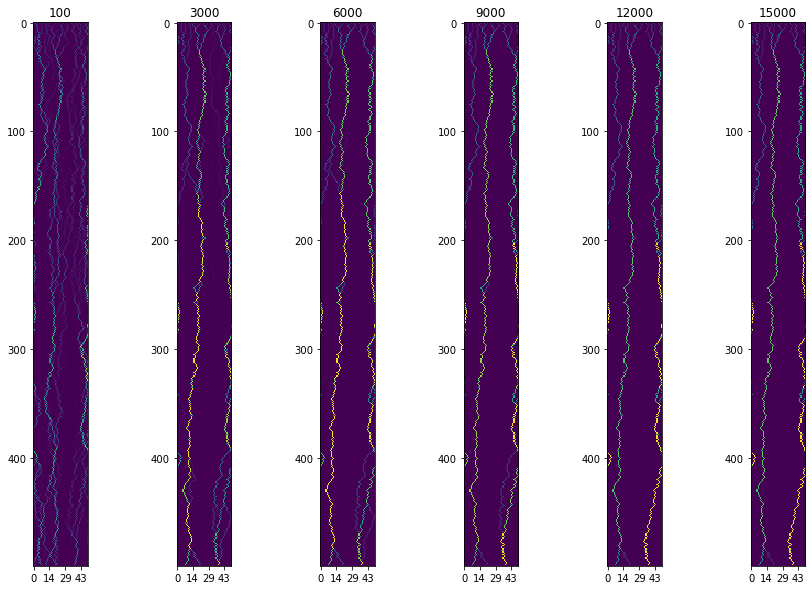

In [128]:
draw_graphs(data_5)

In [130]:
data_6 = run_simulation(target="normal", num_agents=20, num_iterations=15000)

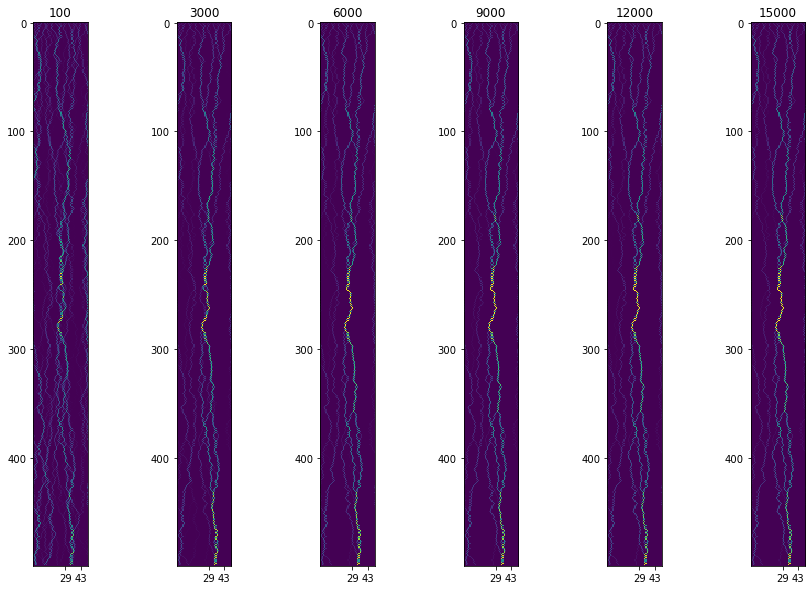

In [136]:
draw_graphs(data_6)

In [141]:
data_7 = run_simulation(target="normal", num_iterations=15000, width=70, height=400)

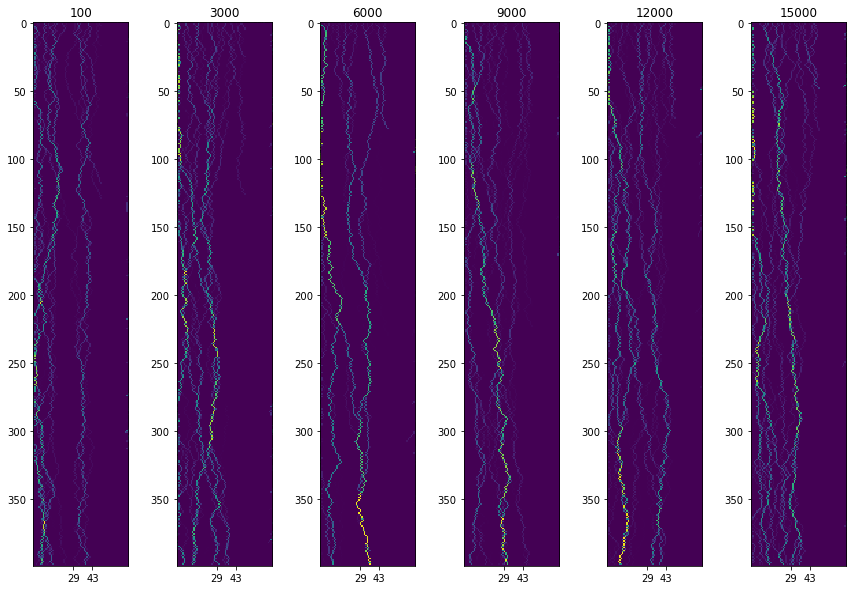

In [142]:
draw_graphs(data_7)